In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a CLARITY brain to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

Next we'll download the image data

In [3]:
refToken = "ara_ccf3"
refImg = imgDownload(refToken)

When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

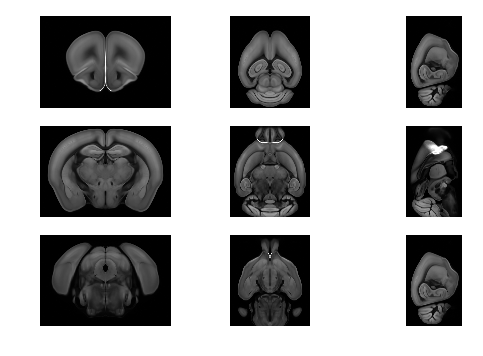

In [4]:
imgShow(refImg, vmax=500)

## Downloading CLARITY brain
Our *input* image will be CLARITY brain AutA.  At full resolution, CLARITY brains can be 1 Terabyte in size, far to large to be downloaded to a personal computer.  Thus *ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [5]:
inToken = "AutA"

nd = neurodata()
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'1', u'0', u'3', u'2', u'5', u'4']


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

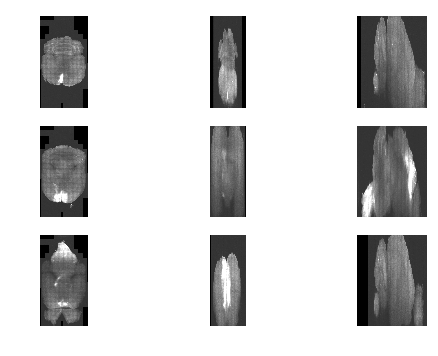

In [6]:
inImg = imgDownload(inToken, resolution=5)
imgShow(inImg, vmax=500)

Let's make a copy of the downloaded image.  We'll need to use it later

In [7]:
inImgSize_download = inImg.GetSize()
inImgSpacing_download = inImg.GetSpacing()

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

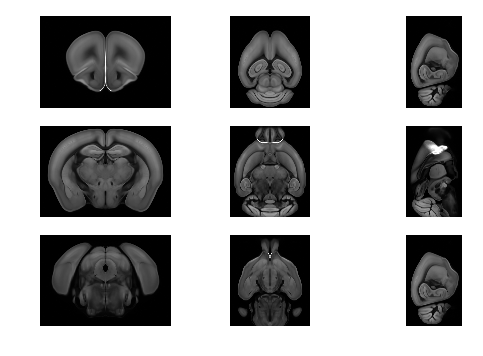

In [8]:
imgShow(refImg, vmax=500)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

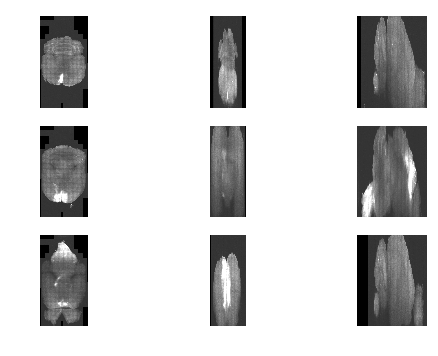

In [9]:
imgShow(inImg, vmax=500)

...we see that the x-axis goes from **R**ight to left, the y-axis goes from **P**osterior to Anterior and the Z axis goes from **S**uperior to Inferior.  Thus it's in **RPS** orientation.  Therefore we reorient the CLARITY image from **RPS** to **RSA**

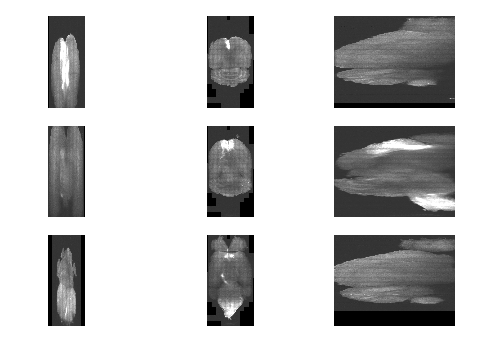

In [10]:
inOrient = "RPS"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=500)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size because we'll need it later.

In [11]:
inImgSize_reorient = inImg.GetSize()

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [12]:
print(inImg.GetSpacing())

(0.01872, 0.005, 0.01872)


In [13]:
print(refImg.GetSpacing())

(0.01, 0.01, 0.01)


Since we are aliging the CLARITY image to a lower resolution atlas we resample it to the resolution atlas.

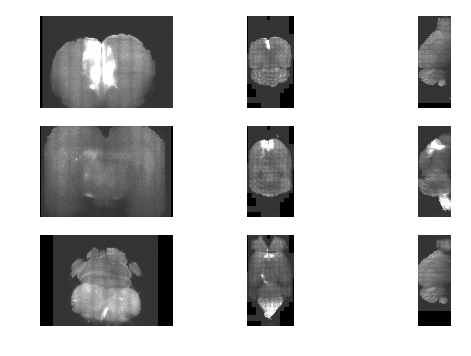

In [14]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

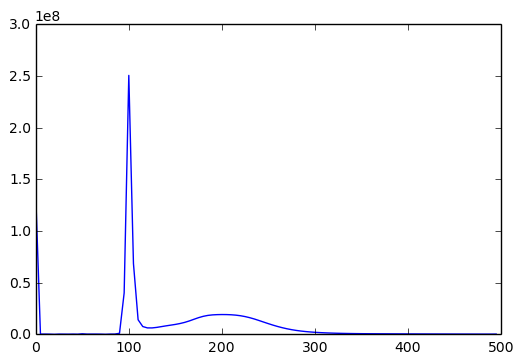

In [15]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.

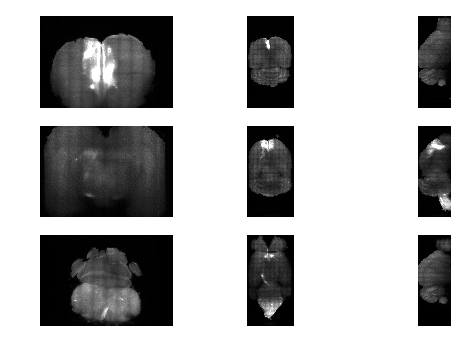

In [16]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

Here's a histogram of the result

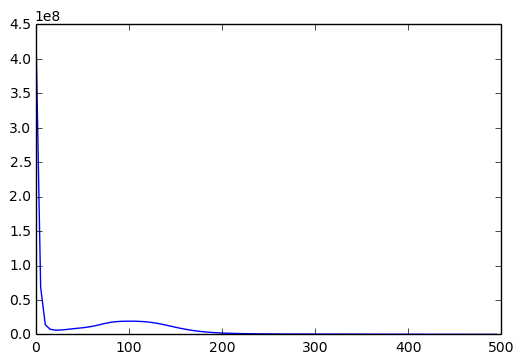

In [17]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

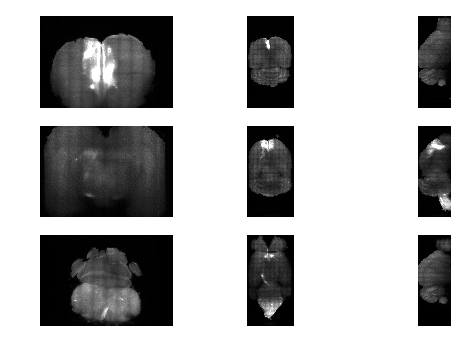

In [18]:
imgShow(inImg, vmax = 500)

To avoid this problem we create a mask which will be used to exclud the top 5% brighest voxels from registration.  To make the mask we first compute the normalized cumulative histogram.

In [19]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

We then find the first value greater than 0.95 (which is 100% - 5%)

In [20]:
maxIndex = np.argmax(cumValues>0.95)-1
threshold = bins[maxIndex]
print(threshold)

204.417


We then threshold the image using this value to obtain a mask

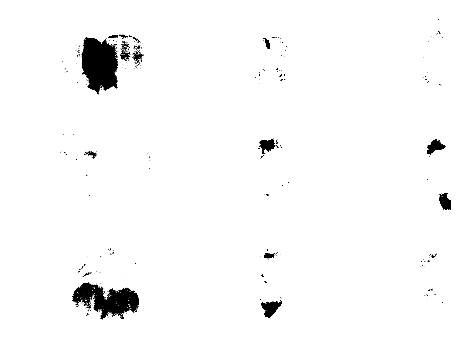

In [21]:
inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

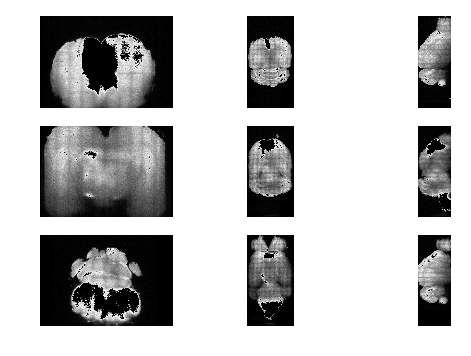

In [22]:
imgShow(imgMask(inImg,inMask))

## Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full atlas scale of 0.01 mm x 0.01 x 0.01 mm but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.1 mm x 0.1mm x 0.1mm

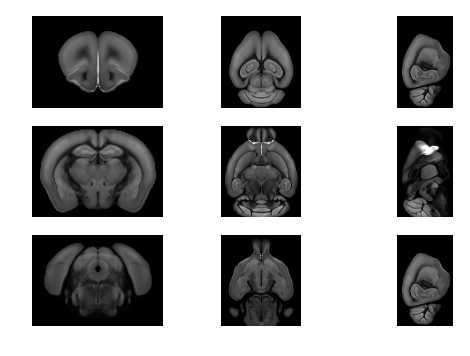

(114, 80, 132)


In [23]:
spacing=[0.1,0.1,0.1]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)
print(refImg_ds.GetSize())

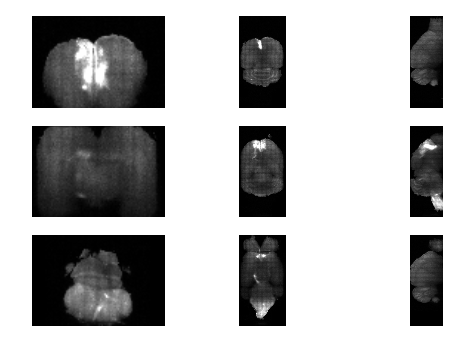

In [24]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)

Notice how we used nearest-neighbor interpolation when downsampling the mask

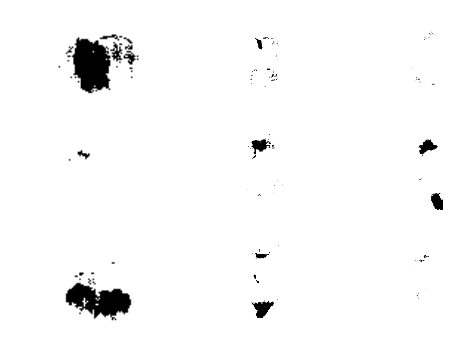

In [25]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [26]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.219364743811
1.	 -0.229129837001
2.	 -0.241002714679
3.	 -0.255086589826
4.	 -0.266185443463
5.	 -0.278747310242
6.	 -0.293164158891
7.	 -0.304291562905
8.	 -0.321767108881
9.	 -0.332327043011
10.	 -0.347461043395
11.	 -0.363444270177
12.	 -0.372377703545
13.	 -0.383514182897
14.	 -0.390060572006
15.	 -0.398318727043
16.	 -0.403945973937
17.	 -0.403725364626
18.	 -0.407903846449
19.	 -0.404289877831
20.	 -0.403453034221
21.	 -0.405389660681
22.	 -0.403764052126
23.	 -0.405505521428
Step rigid:
0.	 -0.422439069306
1.	 -0.324305332131
2.	 -0.419618886454
3.	 -0.404574827249
4.	 -0.449875589325
5.	 -0.447111393724
6.	 -0.458963777105
7.	 -0.455835661986
8.	 -0.460376692235
9.	 -0.462126735425
10.	 -0.465036654613
11.	 -0.464880034761
12.	 -0.465565102721
13.	 -0.46727226299
14.	 -0.467086682915
15.	 -0.468149860973
16.	 -0.468622464769
17.	 -0.469210512795
18.	 -0.469700470009
19.	 -0.470270537492
20.	 -0.470847852943
21.	 -0.471345856628
22.	 -0.471858796245
23.	

Now we apply the affine transform to the input CLARITY image and mask

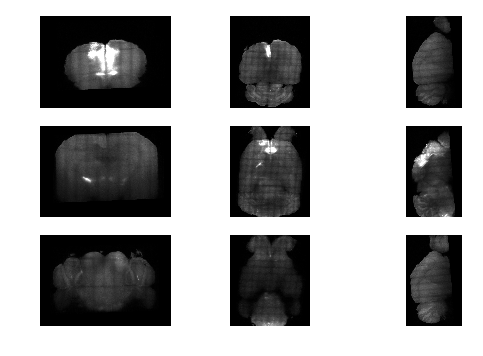

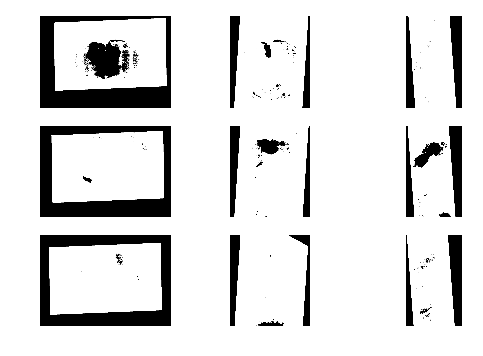

In [27]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.


Step 0: alpha=0.05, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.96168e+10, 0.0588982, 0, -1.96168e+10 (99.6675%), 2.148438e-06
E = -1.96168e+10 (99.6675%)
Length = 0.543016
Time = 14.9877s (0.249795m)

Step 1: alpha=0.02, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.61784e+10, 68.361, 0, -1.61784e+10 (98.6495%), 1.100000e-03
1.	-1.80809e+10, 168.681, 0, -1.80809e+10 (96.8662%), 1.210000e-03
2.	-1.93996e+10, 352.467, 0, -1.93996e+10 (95.6301%), 1.331000e-03
3.	-1.96092e+10, 622.488, 0, -1.96092e+10 (95.4336%), 1.464100e-03
4.	-2.13918e+10, 680.514, 0, -2.13918e+10 (93.7628%), 8.052550e-04
5.	-2.22242e+10, 732.547, 0, -2.22242e+10 (92.9825%), 4.428903e-04
6.	-2.24924e+10, 786.987, 0, -2.24924e+10 (92.7311%), 4.871793e-04
7.	-2.28508e+10, 857.233, 0, -2.28508e+10 (92.3951%), 5.358972e-04
8.	-2.29431e+10, 918.557, 0, -2.29431e+10 (92.3086%), 5.894869e-04
9.	-2.31987e+10, 965.602, 0, -2.31987e+10 (92.069%), 3

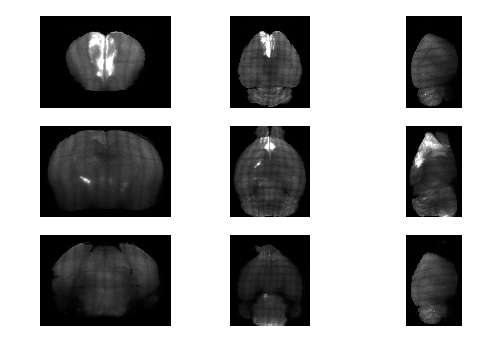

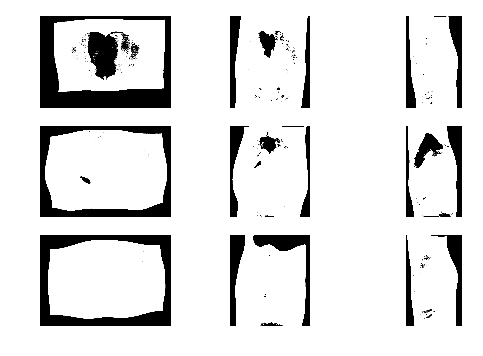

In [28]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], scaleList = [0.25, 0.5, 1.0], useMI=True, iterations=100, verbose=True)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg_lddmm, vmax = 500)
imgShow(inMask_lddmm)

## Evaluating the registration
### Evaluation using checker board
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

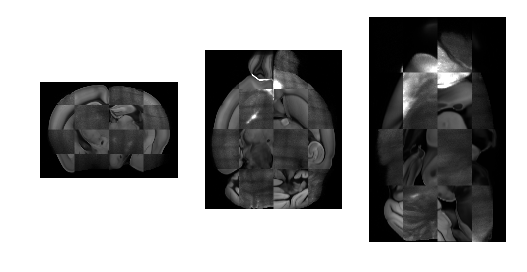

In [29]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), vmax=500, numSlices=1)

## Uploading Results

### Uploading deformed CLARITY image
We can now upload the ARA-aligned CLARITY brain back into ndstore.

In [ ]:
token = "AutA_to_ara3"
imgUpload(inImg_lddmm, token)

### Uploading deformed ARA annotations
Now we download the ARA annotations

In [30]:
refImg = None
inImg_download = None
inImg_reorient = None
inImg_lddmm = None
inImg_affine = None
inMask_affine = None
inMask_lddmm = None

In [31]:
refAnnoImg = imgDownload(refToken, channel="annotation")

In [32]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the ARA annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the ARA space to the space before registration.

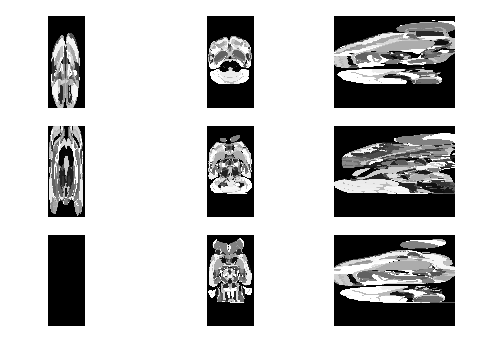

In [34]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=[0.01872, 0.005, 0.01872])
imgShow(inAnnoImg, vmax=1000)

Were not done yet.  We still need to reorient these annotations from **RSA** to **RPS** 

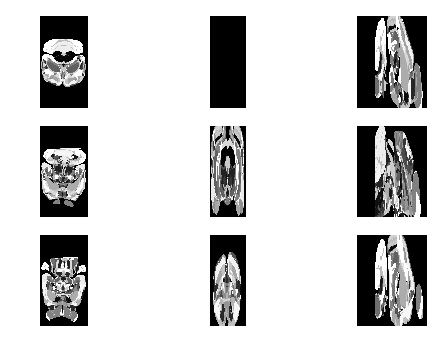

In [35]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=1000)

We can upload these annotations at the lowest possible resolution.

In [38]:
outToken = "ara3_to_AutA"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)